# Introduction
**The goal is to build a model for the median value of housing in a district of California given a finite number of caracteristics.**

The data used is obtained on Kaggle (https://www.kaggle.com/camnugent/california-housing-prices). It contains information from the 1990 California census. 
Note that the data is outdated and the model that we will obtain will be useless at predicting current house prices. The exercise would nonetheless be the same if 
we had up to date housing data.

In this project, we:
- Import and look and the at the dataset
- Perform simple exploratory data analysis
- Pre-process the data and add features based on common-sense assumptions
- Train multiple models on the data and select the one with the best performance
- Tune the best model's hyperparameters
- Predict housing price for unseen data and estimate prediction confidence intervals
- Explain the results obtained using the *Shapash* library.

# Table of Content

# Import Librairies

In [16]:
# Data manipulation
import pandas as pd
import numpy as np

# Data vizualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVR

# Models Evaluation
from sklearn.model_selection import cross_val_score

# Model Tuning
from sklearn.model_selection import GridSearchCV

# Model Explainability
from shapash.explainer.smart_explainer import SmartExplainer
from shapash.data.data_loader import data_loading

# Utils
from math import radians, cos, sin, asin, sqrt
import pickle


# Functions and Classes

In [2]:
def distance(lat1, lat2, lon1, lon2):
    '''
    calculate Distance Between Two Points on Earth 

    Arguments: latitude of point 1, latitude of point 2, longitude of point 1, longitude of point 2
    Returns: Distance between the 2 poitns in KM.
    '''
    
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
 
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

class AddAttributes(BaseEstimator, TransformerMixin):
    '''
    Sklearn transformer for adding attributes to the dataset

    '''
    def __init__(self, add_rooms_per_household = True,
                       add_population_per_household = True,
                       add_bedrooms_per_room = True,
                       add_proximity_to_LA = True,
                       add_proximity_to_SD = True,
                       add_proximity_to_SJ = True,
                       add_proximity_to_SF = True,
                       add_proximity_to_SB = True):
        self.add_rooms_per_household = add_rooms_per_household
        self.add_population_per_household = add_population_per_household
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.add_proximity_to_LA = add_proximity_to_LA
        self.add_proximity_to_SD = add_proximity_to_SD
        self.add_proximity_to_SJ = add_proximity_to_SJ
        self.add_proximity_to_SF = add_proximity_to_SF
        self.add_proximity_to_SB = add_proximity_to_SB
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        # index of columns in df
        longitude_ix = 0
        latitude_ix = 1
        rooms_ix = 3
        households_ix = 6
        population_ix = 5
        bedrooms_ix = 4
        X_ = np.copy(X)
        if self.add_rooms_per_household:
            rooms_per_household = X_[:, rooms_ix] / X_[:, households_ix]
            X_ = np.c_[X, rooms_per_household]
        if self.add_population_per_household:
            population_per_household = X_[:, population_ix] / X_[:, households_ix]
            X_ = np.c_[X_, population_per_household]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X_[:, bedrooms_ix] / X_[:, rooms_ix]
            X_ = np.c_[X_, bedrooms_per_room]
        if self.add_proximity_to_LA:
            LA = [34.052235, -118.243683] # longitude and latitude
            proximity_to_LA = distance(np.repeat(LA[0], X_.shape[0]), np.repeat(LA[1], X_.shape[0]), X_[:, longitude_ix],X_[:, latitude_ix])
            X_ = np.c_[X_, proximity_to_LA]
        if self.add_proximity_to_SD:
            SD = [32.715736, -117.161087] # longitude and latitude
            proximity_to_SD = distance(np.repeat(SD[0], X_.shape[0]), np.repeat(SD[1], X_.shape[0]), X_[:, longitude_ix],X_[:, latitude_ix])
            X_ = np.c_[X_, proximity_to_SD]
        if self.add_proximity_to_SJ:
            SJ = [37.335480, -121.893028] # longitude and latitude
            proximity_to_SJ = distance(np.repeat(SJ[0], X_.shape[0]), np.repeat(SJ[1], X_.shape[0]), X_[:, longitude_ix],X_[:, latitude_ix])
            X_ = np.c_[X_, proximity_to_SJ]
        if self.add_proximity_to_SF:
            SF = [37.773972, -122.431297] # longitude and latitude
            proximity_to_SF = distance(np.repeat(SF[0], X_.shape[0]), np.repeat(SF[1], X_.shape[0]), X_[:, longitude_ix],X_[:, latitude_ix])
            X_ = np.c_[X_, proximity_to_SF]
        if self.add_proximity_to_SB:
            SB = [34.420830, -119.698189] # longitude and latitude
            proximity_to_SB = distance(np.repeat(SB[0], X_.shape[0]), np.repeat(SB[1], X_.shape[0]), X_[:, longitude_ix],X_[:, latitude_ix])
            X_ = np.c_[X_, proximity_to_SB]
        return X_





# Import the Data and Have a First Look

We first need to get a familiar with the dataset. To do so, we:
- Look at the dataframe
- Look at df.info() and df.describe() to get high level informations on the dataset
- Plot histograms for numerical data

The description of the columns is presented below:
1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea


From the above steps, we get the following insights on the dataset:
- The dataset is relatively small (20,640 rows, 10 columns)
- There is a small amount of missing values (207 values) in the total_bedrooms column (**will be adressed in data pre-processing**)
- There is one categorical feature (ocean_proximity)
- The ocean proximity feature contains 5 category (**will be converted in data pre-processing**)
- From the histograms, it is possible to see a bump in the last bin for housing median age, median value and the median income of households. It seems these features were capped in the following way:
    - median income: 0.4999-15.0001 (in ten of thousands of USD)
    - median age: 1-52
    - median value (target for the estimation): 14,999-500,001
- The "capping" **will need to be adressed in the data pre-processing step**.
- The features also are on different scales. The data **will to be scaled**.
- Most of the features have long tails distributions.

We also split the data into train and test sets.


In [20]:
df = pd.read_csv('housing.csv')
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [22]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [23]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

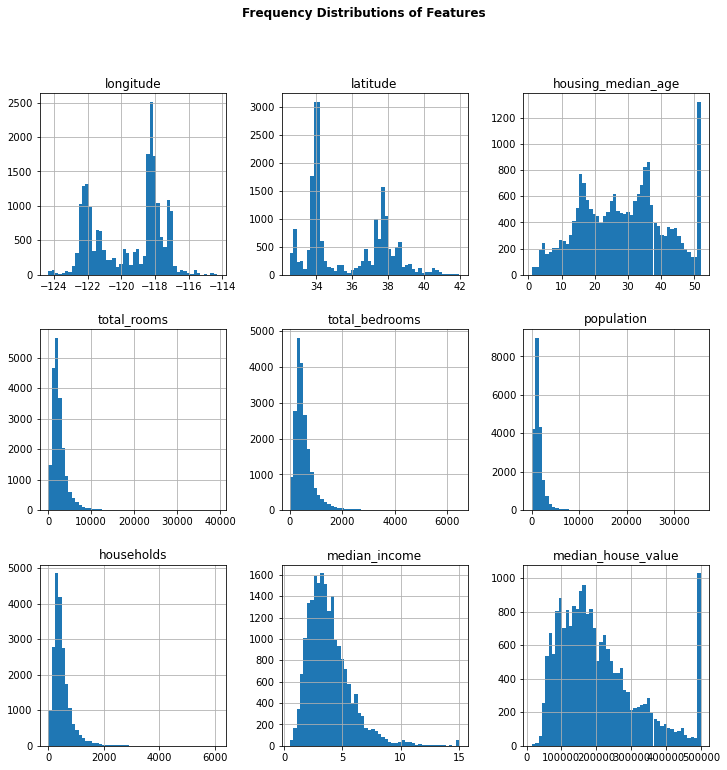

In [24]:
df.hist(bins=50, figsize=(12,12))
pl.suptitle('Frequency Distributions of Features', fontweight="bold")
plt.show()


In [25]:
print(df.shape)
df = df[(df['median_house_value']!=500001.000000) & (df['housing_median_age']!=52.000000)]
df.shape

(20640, 10)


(18572, 10)

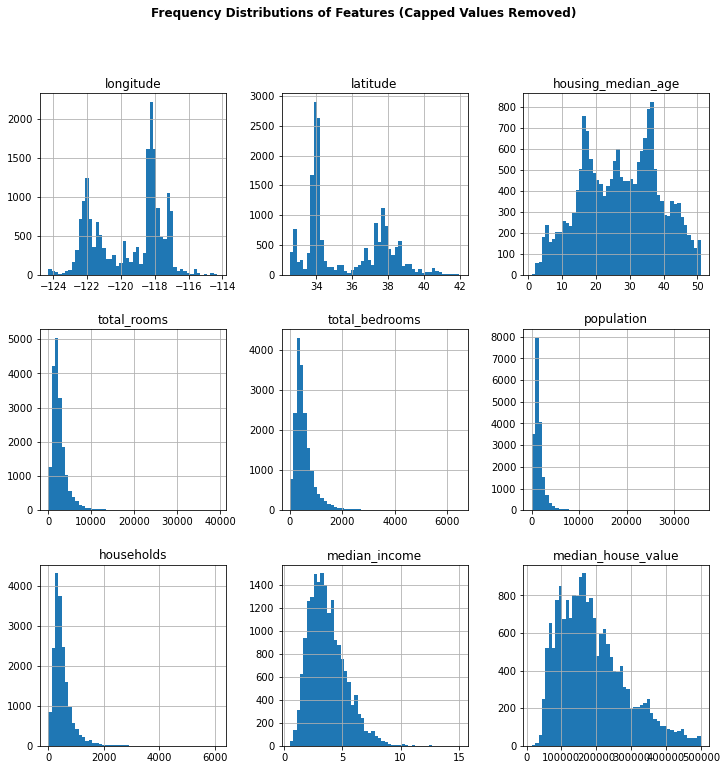

In [26]:
df.hist(bins=50, figsize=(12,12))
pl.suptitle('Frequency Distributions of Features (Capped Values Removed)', fontweight="bold")
plt.show()

## Create a Test Set

In [27]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Exploratory Data Analysis
The next step is to explore the data visually. The hope is to find obvious patterns that we could use (for feature engineering for example).

Let's first state some common sense assumptions on what we expect to see in the data. It is important in my opinion to always state assumptions based on common sense or subject matter expertise before beginning to work on the data. The more complex the data, the more time you should spend learning about the field. Subject matter expertise can lead to intelligent feature engineering that will help the model spot patterns. Below are common sense assumptions for all features:
- longitude and latitude: these should not directly affect house value since the absolute location does not say much about the value of a house, but we could use this information to derive proximity to large cities for example which we expect will affect housing price.
- housing median age: I would expect older housing to be cheaper.
- The number of rooms and bedrooms: we will first need to convert it on a room per household basis. Then it would be interesting in my opinion to have the following features related to rooms:
    - bedrooms/household (I expect more bedrooms to be more expensive)
    - total rooms/household (I expect more rooms to be more expensive)
    - bedrooms/rooms (This is less obvious. Let's wait for the results)
- population and households: I do not expect those 2 to have a significant impact on pricing.
- median income: this feature will probably have a large impact. People that make more money will probably on average buy more expensive houses.

In this section we:
- Look at the price data geographically
- Confirm visually the assumption that house near large cities are more expensive
- Confirm that the feature most correlated with the housing price is the median income



## Geographical Data Vizualization
Lets first look at the data geographically.

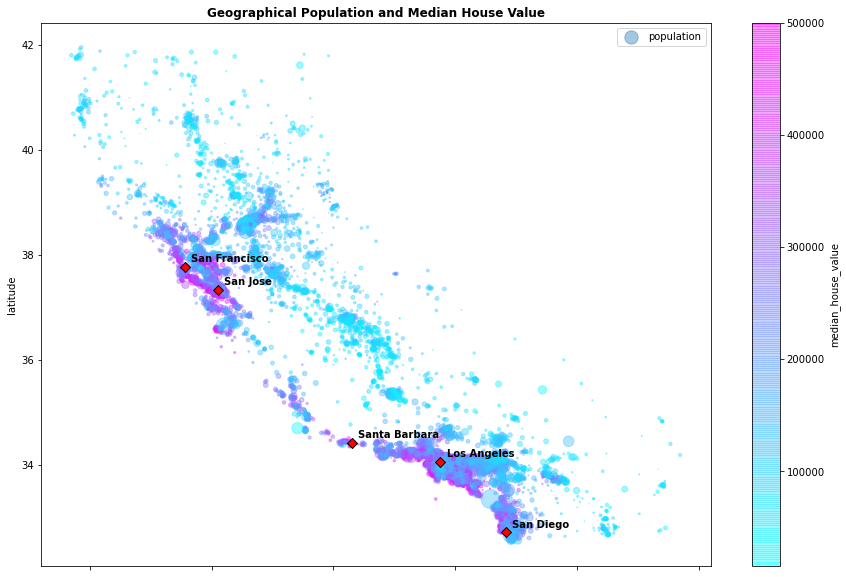

In [28]:
# Base Plot
train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=train["population"]/100, label="population", figsize=(15,10),
c="median_house_value", cmap=plt.get_cmap("cool"), colorbar=True,
)

# Add an annotation to show large cities, longitude and latitudes are stores in lists
# Los Angeles (ref: https://www.latlong.net/place/los-angeles-ca-usa-1531.html)
LA = [34.052235, -118.243683]
# San Diego (ref: https://www.latlong.net/place/san-diego-ca-usa-7073.html)
SD = [32.715736, -117.161087]
# San Jose (ref: https://www.latlong.net/place/downtown-san-jose-ca-usa-22389.html)
SJ = [37.335480, -121.893028]
# San Francisco (ref: https://www.latlong.net/place/san-francisco-ca-usa-594.html)
SF = [37.773972, -122.431297]
# Santa Barbara (ref: https://www.latlong.net/place/santa-barbara-ca-usa-20452.html)
SB = [34.420830, -119.698189]
# Add on plot
cities_names = ['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Santa Barbara']
cities_lat = [34.052235, 32.715736, 37.335480, 37.773972, 34.420830]
cities_long = [-118.243683, -117.161087, -121.893028, -122.431297, -119.698189]

plt.scatter(cities_long, cities_lat, marker='D',s=50, c='r', edgecolors='k')
for i, txt in enumerate(cities_names):
    plt.annotate(cities_names[i], (cities_long[i]+0.1, cities_lat[i]+0.1), c='k', fontweight="bold")

plt.legend()
plt.title('Geographical Population and Median House Value', fontweight="bold")
plt.show()

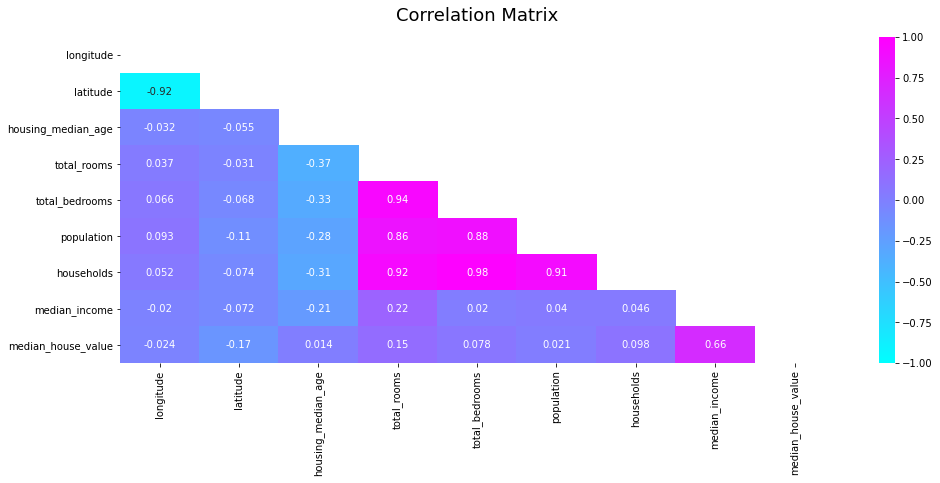

In [29]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train.corr(), dtype=bool))
heatmap = sns.heatmap(train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='cool')
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':18}, pad=16)
plt.show()

# Feature Combinations and Pre-processing Pipelines
As said earlier, we want to combine and modify some of the features so they become more meaningful:
- Get the proximity to large cities
- Get bedrooms/household 
- Get total rooms/household 
- Get bedrooms/rooms
- Get population/household

In this section we:
- Impute missing total bedrooms values using the median
- Add attributes listed above
- Scale the data
- Encode the ocean proximity categorical attribute

In [34]:
target = 'median_house_value'
X_train = train.drop(target, axis=1) # drop create a copy of the original
y_train = train[target].copy()
X_test = test.drop(target, axis=1) # drop create a copy of the original
y_test = test[target].copy()

categorical_attr = ['ocean_proximity']
numerial_attr = [i for i in X_train.columns.to_list() if not i in categorical_attr]

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', AddAttributes()),
    ('std_scaler', StandardScaler()),
])

preproc_pipeline = ColumnTransformer([
    ("num", numerical_pipeline, numerial_attr),
    ("cat", OneHotEncoder(), categorical_attr),
])

X_train_prepared = preproc_pipeline.fit_transform(X_train)
X_test_prepared = preproc_pipeline.fit_transform(X_test)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns=['Longitude', 'Latitude', 'Housing Median Age', 'Total Rooms', 'Total Bedrooms', 'Population', 'Households', 'Median Income', 
                                                            'Rooms per Household', 'Population per Household', 'Bedrooms per Room', 'Proximity to Los Angeles', 'Proximity to San Diego', 'Proximity to San Jose', 'Proximity to San Francisco', 'Proximity to Santa Barbara',
                                                            'Near Bay', '<1h Ocean', 'Inland', 'Near Ocean', 'Island'])


# Model Training and Evaluation

We tested 9 popular models for the regression problem. CatBoost had the best performance and was selected for tuning.

In [128]:
#LinearRegression()
models = [
    SGDRegressor(),  
    ElasticNet(), 
    BayesianRidge(), 
    LGBMRegressor(), 
    XGBRegressor(), 
    CatBoostRegressor(),
    GradientBoostingRegressor(), 
    RandomForestRegressor(), 
    SVR()
]
model_names = [
    'SGDRegressor',  
    'ElasticNet', 
    'BayesianRidge', 
    'LGBMRegressor', 
    'XGBRegressor', 
    'CatBoostRegressor',
    'GradientBoostingRegressor', 
    'RandomForestRegressor', 
    'SVR'
]

i = 0
scores_summary = []
for model in models:
    i += 1
    print(i, '------------------------------------')
    regressor = model.fit(X_train_prepared, y_train)
    scores = cross_val_score(regressor, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
    rmse = np.sqrt(-scores)
    mean_rmse = rmse.mean()
    std_rmse = rmse.std()
    scores_summary.append((model_names[i-1], mean_rmse, std_rmse))

scores_summary = pd.DataFrame(scores_summary, columns=['Model', 'Mean RMSE', 'STD RMSE'])


1 ------------------------------------
2 ------------------------------------
3 ------------------------------------
4 ------------------------------------
5 ------------------------------------
6 ------------------------------------
Learning rate set to 0.063096
0:	learn: 91753.2386947	total: 13.2ms	remaining: 13.2s
1:	learn: 88555.9968859	total: 17.6ms	remaining: 8.8s
2:	learn: 85651.5679958	total: 22.5ms	remaining: 7.47s
3:	learn: 83017.1920036	total: 27.8ms	remaining: 6.92s
4:	learn: 80517.8475144	total: 32.6ms	remaining: 6.5s
5:	learn: 78348.8116575	total: 37.8ms	remaining: 6.25s
6:	learn: 76246.3207806	total: 43.7ms	remaining: 6.21s
7:	learn: 74267.6076021	total: 48.7ms	remaining: 6.03s
8:	learn: 72496.3178314	total: 54.3ms	remaining: 5.98s
9:	learn: 70884.7934268	total: 59.5ms	remaining: 5.89s
10:	learn: 69332.9154580	total: 64ms	remaining: 5.76s
11:	learn: 67947.6477916	total: 69.1ms	remaining: 5.68s
12:	learn: 66681.5420483	total: 73.9ms	remaining: 5.61s
13:	learn: 65551.52888

In [129]:
scores_summary.sort_values(by='Mean RMSE', ascending=True)

,Model,Mean RMSE,STD RMSE
5,CatBoostRegressor,3.929103e+04,1.697761e+03
3,LGBMRegressor,4.083135e+04,1.703162e+03
4,XGBRegressor,4.170367e+04,1.883225e+03
7,RandomForestRegressor,4.399892e+04,1.327302e+03
6,GradientBoostingRegressor,4.693667e+04,1.235143e+03
2,BayesianRidge,5.820893e+04,1.375509e+03
1,ElasticNet,6.661262e+04,1.532906e+03
8,SVR,9.683880e+04,1.935300e+03
0,SGDRegressor,1.843394e+08,3.611502e+08


# Tuning the Best Model

We tuned the catboost model and compared it against an autoML tool developped by Microsoft (FlaML). The performance between the model we train and the one obtained by the autoML tool were very similar.

## First-Pass Tuning of the Categorical Boosting Regressor

In [130]:
model_CBR = CatBoostRegressor()

parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1, 1],
              'iterations'    : [30, 50, 100, 200]
            }

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train_prepared, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

0:	learn: 89585.3175471	total: 77.4ms	remaining: 15.4s
1:	learn: 84411.2588588	total: 127ms	remaining: 12.6s
2:	learn: 79929.5973182	total: 175ms	remaining: 11.5s
3:	learn: 76092.3565594	total: 220ms	remaining: 10.8s
4:	learn: 72529.2450575	total: 272ms	remaining: 10.6s
5:	learn: 69393.4345071	total: 326ms	remaining: 10.5s
6:	learn: 66521.0148648	total: 375ms	remaining: 10.3s
7:	learn: 64161.8193518	total: 425ms	remaining: 10.2s
8:	learn: 62135.3353504	total: 474ms	remaining: 10.1s
9:	learn: 60224.0840896	total: 520ms	remaining: 9.88s
10:	learn: 58633.0372658	total: 568ms	remaining: 9.76s
11:	learn: 57176.0240910	total: 620ms	remaining: 9.71s
12:	learn: 55926.4298777	total: 666ms	remaining: 9.59s
13:	learn: 54778.1653124	total: 710ms	remaining: 9.44s
14:	learn: 53660.2494305	total: 762ms	remaining: 9.39s
15:	learn: 52723.0973925	total: 814ms	remaining: 9.36s
16:	learn: 51872.2967758	total: 870ms	remaining: 9.37s
17:	learn: 51058.7339323	total: 922ms	remaining: 9.32s
18:	learn: 50489.12

In [131]:
model_CBR = CatBoostRegressor()

parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.1, 0.5, 1],
              'iterations'    : [100, 150, 200, 250]
            }

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train_prepared, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

0:	learn: 89555.2495569	total: 16.5ms	remaining: 4.1s
1:	learn: 84654.8195887	total: 27ms	remaining: 3.35s
2:	learn: 80173.9767074	total: 37.4ms	remaining: 3.08s
3:	learn: 76348.2459586	total: 47ms	remaining: 2.89s
4:	learn: 72828.3607957	total: 56ms	remaining: 2.75s
5:	learn: 69942.0379136	total: 64.7ms	remaining: 2.63s
6:	learn: 67394.5453370	total: 73.3ms	remaining: 2.55s
7:	learn: 64988.4889758	total: 82.3ms	remaining: 2.49s
8:	learn: 63016.7363843	total: 91ms	remaining: 2.44s
9:	learn: 61207.7446648	total: 100ms	remaining: 2.4s
10:	learn: 59749.6767541	total: 109ms	remaining: 2.37s
11:	learn: 58350.3261444	total: 118ms	remaining: 2.33s
12:	learn: 57256.0514635	total: 126ms	remaining: 2.3s
13:	learn: 56181.2666471	total: 135ms	remaining: 2.27s
14:	learn: 55278.3173152	total: 144ms	remaining: 2.25s
15:	learn: 54357.7250707	total: 152ms	remaining: 2.23s
16:	learn: 53630.2974267	total: 161ms	remaining: 2.21s
17:	learn: 52996.5974804	total: 171ms	remaining: 2.2s
18:	learn: 52432.981579

In [132]:
model_CBR = CatBoostRegressor()

parameters = {'depth'         : [5,10,20],
              'learning_rate' : [0.1, 0.25, 0.5],
              'iterations'    : [1000, 1500]
            }

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 3, n_jobs=-1)
grid.fit(X_train_prepared, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.82269182 0.81820703 0.80293898 0.82462613 0.81700023 0.80069111
 0.8216956  0.81030134 0.78725379 0.82150872 0.81016052 0.78724162
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


0:	learn: 90083.2619987	total: 5.96ms	remaining: 8.94s
1:	learn: 85330.4758065	total: 9.68ms	remaining: 7.25s
2:	learn: 81453.6166403	total: 13.5ms	remaining: 6.72s
3:	learn: 77897.9194555	total: 17.2ms	remaining: 6.43s
4:	learn: 74766.0886245	total: 20.5ms	remaining: 6.14s
5:	learn: 72000.4059901	total: 24.1ms	remaining: 5.99s
6:	learn: 69703.1597069	total: 27.3ms	remaining: 5.83s
7:	learn: 67635.9619290	total: 30.8ms	remaining: 5.75s
8:	learn: 65834.7840190	total: 34.3ms	remaining: 5.68s
9:	learn: 64380.1515491	total: 37.8ms	remaining: 5.63s
10:	learn: 63097.2137938	total: 41.4ms	remaining: 5.6s
11:	learn: 61855.8492296	total: 45ms	remaining: 5.58s
12:	learn: 60678.1291769	total: 48.6ms	remaining: 5.56s
13:	learn: 59762.7826803	total: 52.4ms	remaining: 5.56s
14:	learn: 58928.7770297	total: 56.1ms	remaining: 5.56s
15:	learn: 58210.7040191	total: 60.5ms	remaining: 5.61s
16:	learn: 57459.4646528	total: 64.6ms	remaining: 5.63s
17:	learn: 56980.3682500	total: 69.8ms	remaining: 5.74s
18:	l

In [133]:
X_test_perpared = preproc_pipeline.fit_transform(X_test)
model = CatBoostRegressor(**grid.best_params_)
model.fit(X_train_prepared, y_train)
y_test_predicted = model.predict(X_test_perpared)

0:	learn: 90083.2619987	total: 6.22ms	remaining: 9.32s
1:	learn: 85330.4758065	total: 10.4ms	remaining: 7.79s
2:	learn: 81453.6166403	total: 13.7ms	remaining: 6.82s
3:	learn: 77897.9194555	total: 16.4ms	remaining: 6.15s
4:	learn: 74766.0886245	total: 20.3ms	remaining: 6.08s
5:	learn: 72000.4059901	total: 23.8ms	remaining: 5.92s
6:	learn: 69703.1597069	total: 27.3ms	remaining: 5.81s
7:	learn: 67635.9619290	total: 30.2ms	remaining: 5.63s
8:	learn: 65834.7840190	total: 33.1ms	remaining: 5.49s
9:	learn: 64380.1515491	total: 36.3ms	remaining: 5.4s
10:	learn: 63097.2137938	total: 39.8ms	remaining: 5.39s
11:	learn: 61855.8492296	total: 43.5ms	remaining: 5.4s
12:	learn: 60678.1291769	total: 46.7ms	remaining: 5.34s
13:	learn: 59762.7826803	total: 50.2ms	remaining: 5.33s
14:	learn: 58928.7770297	total: 53.9ms	remaining: 5.34s
15:	learn: 58210.7040191	total: 57.6ms	remaining: 5.34s
16:	learn: 57459.4646528	total: 61.3ms	remaining: 5.35s
17:	learn: 56980.3682500	total: 65.1ms	remaining: 5.36s
18:	

In [134]:
from flaml import AutoML

automl = AutoML()

automl_settings = {
    "time_budget": 600,  # in seconds
    "metric": 'r2',
    "task": 'regression'
}

# Train with labeled input data
automl.fit(X_train=X_train_prepared, y_train=y_train,
           **automl_settings)
# Predict
y_test_predicted2 = automl.predict(X_test_perpared)
# Export the best model
print(automl.model)

with open('automl2.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

[flaml.automl: 10-06 20:25:18] {1219} INFO - Evaluation method: cv
[flaml.automl: 10-06 20:25:18] {698} INFO - Using RepeatedKFold
[flaml.automl: 10-06 20:25:18] {1250} INFO - Minimizing error metric: 1-r2
[flaml.automl: 10-06 20:25:18] {1274} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
[flaml.automl: 10-06 20:25:18] {1457} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-06 20:25:18] {1614} INFO -  at 0.1s,	best lgbm's error=0.7275,	best lgbm's error=0.7275
[flaml.automl: 10-06 20:25:18] {1457} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-06 20:25:19] {1614} INFO -  at 0.3s,	best lgbm's error=0.7275,	best lgbm's error=0.7275
[flaml.automl: 10-06 20:25:19] {1457} INFO - iteration 2, current learner lgbm
[flaml.automl: 10-06 20:25:19] {1614} INFO -  at 0.4s,	best lgbm's error=0.5051,	best lgbm's error=0.5051
[flaml.automl: 10-06 20:25:19] {1457} INFO - iteration 3, current learner xgboost
[flaml.automl: 10-06 20:2

R2 is 0.78441417150145
RMSE is 45543.06721397112
95% confidence interval on RMSE is [[43498.12740877 47500.05109937]].


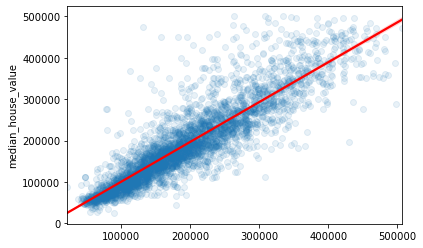

In [ ]:
from scipy import stats
from sklearn.metrics import mean_squared_error
confidence = 0.95

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

rmse = sqrt(mean_squared_error(y_test_predicted, y_test))
squared_errors = (y_test_predicted - y_test) ** 2
CI = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))


print('R2 is ' + str(r2(y_test_predicted, y_test)))
print('RMSE is ' + str(rmse))
print('95% confidence interval on RMSE is ' + str(CI) + '.')

sns.regplot(x=y_test_predicted, y=y_test, scatter_kws={'alpha':0.10}, line_kws={'color': 'red'})
plt.title('Test vs Predicted Test Pricing (Sklearn Model)')
plt.show()

R2 is 0.7924009506362476
RMSE is 44578.23747654439
95% confidence interval on RMSE is [43498.12740877 47500.05109937].


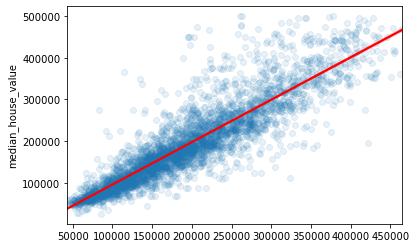

In [ ]:
rmse = sqrt(mean_squared_error(y_test_predicted2, y_test))

print('R2 is ' + str(r2(y_test_predicted2, y_test)))
print('RMSE is ' + str(rmse))
print('95% confidence interval on RMSE is ' + str(CI) + '.')

sns.regplot(x=y_test_predicted2, y=y_test, scatter_kws={'alpha':0.10}, line_kws={'color': 'red'})
plt.title('Test vs Predicted Test Pricing (FlaML Model)')
plt.show()

In [100]:
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

with open('sklearn.pkl', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

# Model Explainability

In [14]:
with open('sklearn.pkl', 'rb') as f:
    clf = pickle.load(f)
clf


In [49]:
xpl = SmartExplainer()
xpl.compile(
    x=X_test_prepared_df,
    model=clf,
)
xpl.run_app(title_story='California Housing')


Backend: Shap TreeExplainer
Dash is running on http://0.0.0.0:8050/



C:\Users\deli91358\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:1549: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.

INFO:root:Your Shapash application run on http://H-4BPmLMPxKhgxM:8050/


Dash is running on http://0.0.0.0:8050/



INFO:root:Use the method .kill() to down your app.
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



<CustomThread(Thread-147, started 92696)>

 * Serving Flask app 'shapash.webapp.smart_app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://10.110.8.68:8050/ (Press CTRL+C to quit)
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:21] "GET / HTTP/1.1" 200 -
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:21] "GET /assets/material-icons.css?m=1627319022.651196 HTTP/1.1" 304 -
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:21] "GET /assets/style.css?m=1627319022.6541867 HTTP/1.1" 304 -
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:21] "GET /assets/jquery.js?m=1627319022.650199 HTTP/1.1" 304 -
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:21] "GET /assets/main.js?m=1627319022.651196 HTTP/1.1" 304 -
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:22] "GET /_dash-dependencies HTTP/1.1" 200 -
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:22] "GET /_dash-layout HTTP/1.1" 200 -
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:22] "GET /assets/shapash-fond-fonce.png HTTP/1.1" 304 -
INFO:werkzeug:10.110.8.68 - - [11/Oct/2021 20:53:22] "GET /assets/settings.png HTTP/1.1" 304 -
INFO:werkz

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\flask\app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\flask\app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\flask\app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\flask\app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\deli91358\AppData\Local\Programs\Python\Python39\lib\site-packages\dash\dash.py", line 1076, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\deli91358\AppData\Local\Programs\Python\Pytho

ERROR:shapash.webapp.smart_app:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\flask\app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\flask\app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\flask\app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\deli91358\AppData\Roaming\Python\Python39\site-packages\flask\app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\deli91358\AppData\Local\Programs\Python\Python39\lib\site-packages\dash\dash.py", line 1076, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\deli91358\AppD